Careful, these constants may be different for you:

In [7]:
DATA_PATH = '~/Desktop/sdss_dr7_photometry_source.csv.gz'

In [8]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.neighbors

%matplotlib inline

In [9]:
PSF_COLS = ('psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z')

First import the training and testing sets

In [10]:
def load_data(x_cols=PSF_COLS,
              class_col='class',
              class_val='Galaxy',
              train_samples_num=1000000):
    
    # Cast x_cols to list so Pandas doesn't complain…
    x_cols_l = list(x_cols)

    data_iter = pd.read_csv(
        DATA_PATH,
        iterator=True,
        chunksize=100000,
        usecols=x_cols_l + [class_col])

    # Filter out anything that is not a galaxy without loading the whole file into memory.
    data = pd.concat(chunk[chunk[class_col] == class_val]
                     for chunk in data_iter)

    train_X = data[:train_samples_num][x_cols_l].as_matrix()
    assert train_X.shape == (train_samples_num, len(x_cols))
    return train_X


data = load_data()

Fit the training data.

In [11]:
def fit(train_X,
        bandwidth=1,  # By experimentation.
        kernel='epanechnikov',  # Resembles Gaussian within short distance, but is faster.
        leaf_size=400,  # For speed.
        rtol=1e-3):  # Decreased accuracy, but better speed.
    estimator = sklearn.neighbors.KernelDensity(bandwidth=bandwidth,
                                                kernel=kernel,
                                                leaf_size=leaf_size,
                                                rtol=rtol)
    estimator.fit(train_X)
    return estimator


kde = fit(data)

# Sanity checks
## One variable
First we plot the expected estimated density as a function of each of the five variables. We expect the function and the histogram to match.

In [12]:
def make_5D_grid(train_X,
                 grid_samples_per_axis=20):  # Careful! This code is O(n^5) in this variable
    mins = np.min(train_X, axis=0)
    maxs = np.max(train_X, axis=0)
    assert mins.shape == maxs.shape == (train_X.shape[1],)
    
    # Produce the 5D grid. This is surprisingly nontrivial.
    # http://stackoverflow.com/questions/28825219/
    linspaces = [np.linspace(i, j, grid_samples_per_axis)
                 for i, j in zip(mins, maxs)]
    mesh_grids = np.meshgrid(*linspaces,
                             indexing='ij')  # Otherwise numpy swaps the first two dimensions… 😕

    sample_points = np.array(mesh_grids)
    return sample_points


grid = make_5D_grid(data)

In [17]:
def evaluate_density_at_sample_points(estimator, sample_points):
    dims = sample_points.shape[0]
    samples_per_axis = sample_points.shape[1]
    assert sample_points.shape[1:] == (samples_per_axis,) * dims

    sample_points = np.reshape(sample_points, (dims, samples_per_axis ** dims))
    densities = estimator.score_samples(sample_points.T)
    densities = np.reshape(densities, (samples_per_axis,) * dims)
    
    # Convert from log densities
    densities = np.exp(densities)
    
    return densities
    

grid_densities = evaluate_density_at_sample_points(kde, grid)

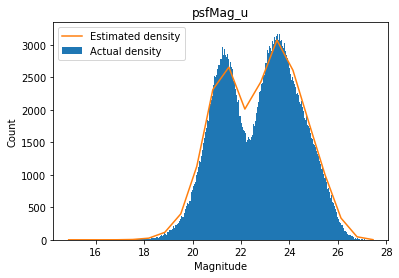

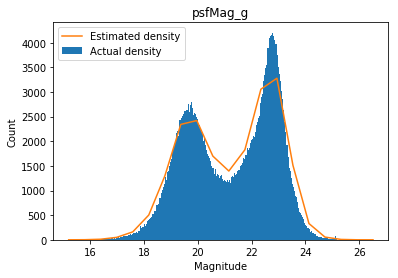

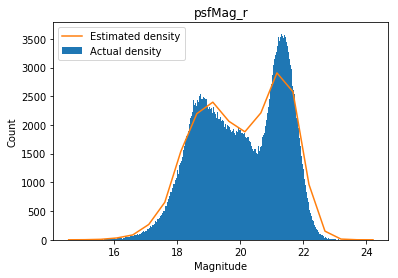

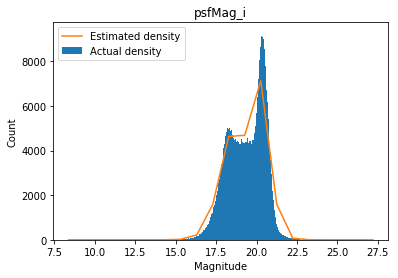

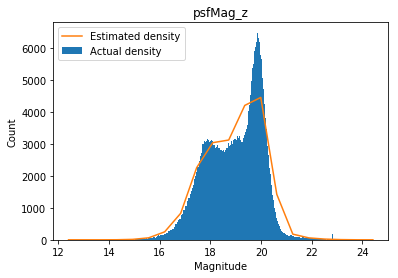

In [20]:
def plot_against_one_variable(train_X, sample_points, densities,
                              bands=PSF_COLS,
                              bins=1000,
                              scale_coeff=2500):
    dims = len(bands)
    assert train_X.shape[1] == sample_points.shape[0] == dims
    assert sample_points.shape[1:] == densities.shape
    
    for i in range(dims):
        fig, axes = plt.subplots()
        
        # Make histogram.
        axes.hist(train_X[:,i],  # We only care about one of the five dimensions.
                  bins=bins,
                  label='Actual density')
        
        # Make plot of estimated densities.
        x_indices = tuple(0 if a != i else slice(None)  # Linspace over
                          for a in range(dims))         # i-th dimension.
        x_indices = (i,) + x_indices  # Only take i-th dimension. Due to the
                                      # above others are constant anyway.
        
        x = sample_points[x_indices]
        assert len(x.shape) == 1  # Sanity check to ensure it is 1D.
        
        
        y_sum_axes = tuple(a for a in range(dims) if a != i) # Sum over all dimensions except i.
        y = np.sum(densities, axis=y_sum_axes)
        y *= scale_coeff
        assert y.shape == x.shape
        
        axes.plot(x, y, label='Estimated density')
        
        # Labels
        plt.ylabel('Count')
        plt.xlabel('Magnitude')
        plt.title(bands[i])
        plt.legend()
        
    
plot_against_one_variable(data, grid, grid_densities)

## Two variables
We also plot densities for each pair of variables.

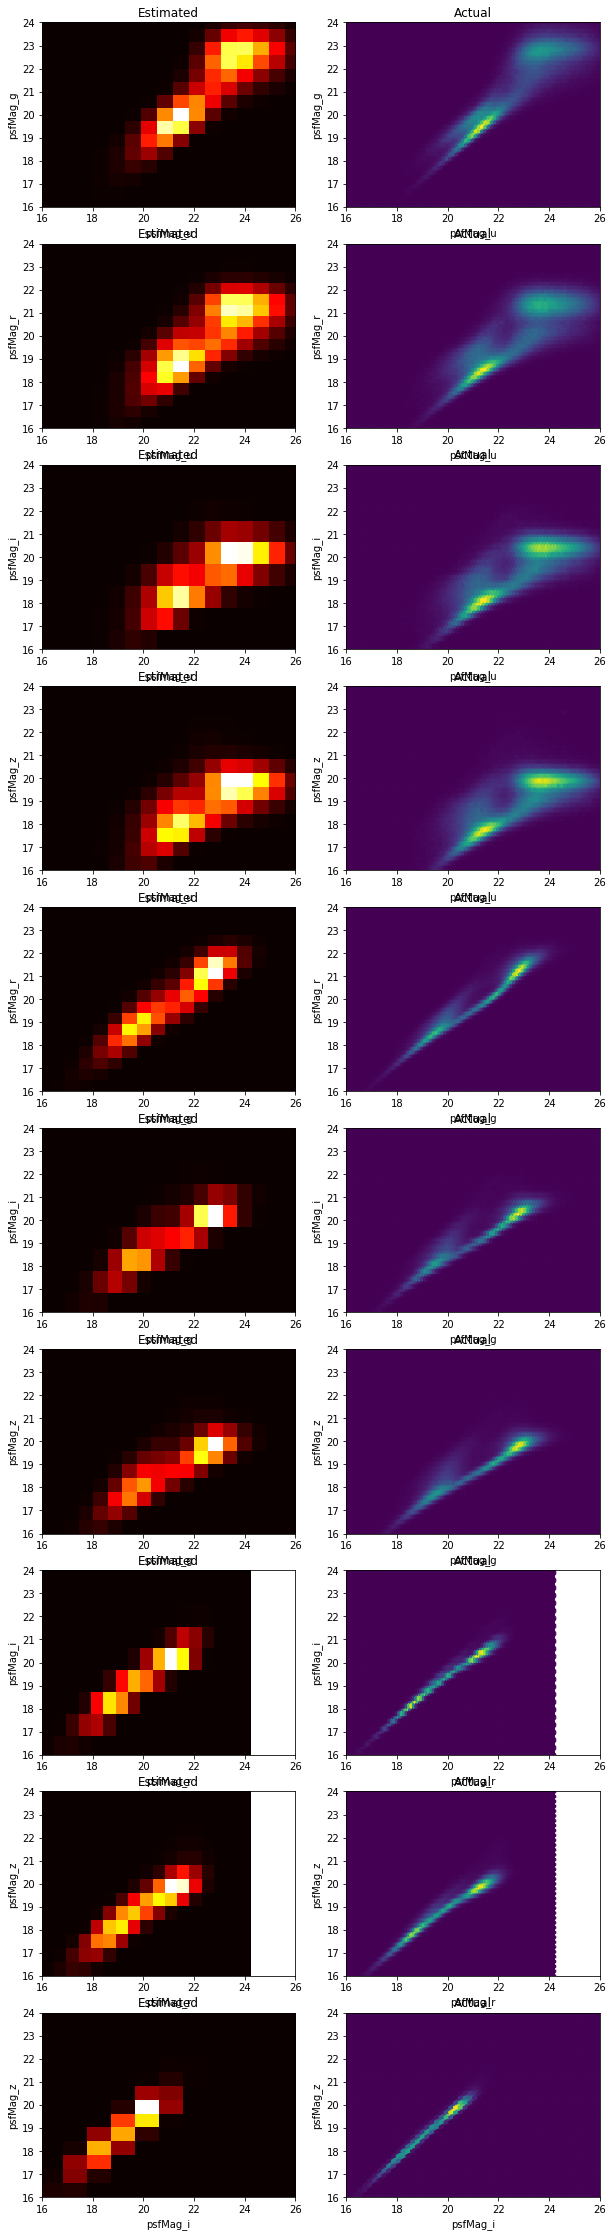

In [46]:
def plot_against_two_variables(train_X, sample_points, densities,
                               bands=PSF_COLS,
                               bins=1000):
    dims = len(bands)
    assert train_X.shape[1] == sample_points.shape[0] == dims
    assert sample_points.shape[1:] == densities.shape
    
    
    mins = sample_points[(slice(None),) + (0,) * dims]
    maxs = sample_points[(slice(None),) + (-1,) * dims]
    plt.figure(figsize=(10, 40))
    upto = 1
    for i in range(dims):
        for j in range(i + 1, dims):
            plt.subplot((dims ** 2 - dims) // 2, 2, upto)
            upto += 1
            z_sum_axes = tuple(a for a in range(dims) if a != i and a != j) # Sum over all dimensions except i.
            z = np.sum(densities, axis=z_sum_axes)
            
            extent = [mins[i], maxs[i], mins[j], maxs[j]]
#             plt.axis(extent)
            
            plt.imshow(z.T,
                       cmap='hot',
                       interpolation='nearest',
                       extent=extent,
                       aspect='auto',
                       origin='lower')
            
            plt.xlabel(bands[i])
            plt.ylabel(bands[j])
            plt.title('Estimated')
            plt.xlim((16, 26))
            plt.ylim((16, 24))
            
            plt.subplot((dims ** 2 - dims) // 2, 2, upto)
            upto += 1
            plt.hexbin(train_X[:,i], train_X[:,j], gridsize=100)
            
            plt.xlabel(bands[i])
            plt.ylabel(bands[j])
            plt.title('Actual')
            plt.xlim((16, 26))
            plt.ylim((16, 24))
        
    
plot_against_two_variables(data, grid, grid_densities)